In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
#from sklearn import linear_model, datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn import metrics
from skimage.transform import resize
from skimage.io import imread_collection, imshow

In [2]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 77x65 images in X around by 1px to left, right, down, up
    Credit to SciKitLearn (linked above)
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((77, 65)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [3]:
# IMPORT IMAGES
imgs = imread_collection('C:/Users/DJ/Documents/AnacondaPython/Thinkful/FilesToLoad/YALE/centered/*.pgm')
print("{} images".format(len(imgs)))

165 images


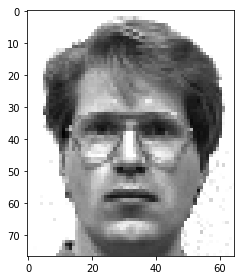

In [4]:
# RESIZE TO AVOID MEM ISSUES AND IMPROV PERFORMANCE
# REDUCE VECTOR OF 38,115 (231x165) TO 5,005 (77x65)
imgs = [resize(x,(77,65), mode='constant', anti_aliasing=False) for x in imgs]

#Show an example of a reduced image
imshow(imgs[1])

In [5]:
# FLATTEN ALL IMAGES TO ARRAYS
imgsarr = [x.flatten('C') for x in imgs]
X = np.asarray(imgsarr, 'float32')

In [6]:
# CREATE A TARGET VARIABLE 
# 15 SUBJECTS, AND 11 IMAGES FOR EACH SUBJECT
# CREATING AN ARRAY, POPULATED WITH NUMBERS, EACH NUMBER 1-15 REPEATED 11 TIMES

# ??? CRYPTIC, SECOND PIECE DON'T REALLY UNDERSTAND
# !!! ASK ZACH
# NESTED ARRAYS TO BE USED AS LABELS
y = [[_ for i in range(1,12)] for _ in range(1,16)]

In [7]:
print(y)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11], [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13], [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]]


In [8]:
# ??? CRYPTIC, DON'T REALLY UNDERSTAND
# !!! ASK ZACH
# NESTED INTO ONE ARRAY TO BE USED AS LABELS?
y = [num for sub in y for num in sub]

In [9]:
print(y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


In [10]:
# BernoulliRBM MODEL FOR FEATURE GENERATION
rbm = BernoulliRBM(random_state=0, verbose=True, learning_rate=.01, n_iter=20, 
                   n_components=150)

# LOGISTIC REGRESSION FOR CLASSIFICATION
logistic = LogisticRegression(solver='lbfgs', max_iter=10000, C=6000, 
                              multi_class='multinomial')

# PIPELINE 
rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

In [11]:
rbm_features_classifier.fit(imgsarr, y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -2859.07, time = 0.70s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3044.42, time = 0.62s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -2666.64, time = 0.58s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -2527.39, time = 0.49s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -2475.21, time = 0.66s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -2468.15, time = 0.52s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2482.79, time = 0.43s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -2466.78, time = 0.46s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -2459.73, time = 0.45s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2439.38, time = 0.45s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -2472.57, time = 0.48s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2450.07, time = 0.45s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -2407.18, time = 0.68s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -2440.01, time = 0.44s
[

Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.01,
                              n_components=150, n_iter=20, random_state=0,
                              verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [12]:
# CONFIRM SUCCESS BY PREDICTING ON ALL DATA
Y_pred = rbm_features_classifier.predict(imgsarr)

print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y, Y_pred)))

# ??? FIT USING y, ISN'T THIS SNOOPING AND A BAD PRACTICE, GUY USED TO SHOW FEATURE CREATION
# !!! ASK ZACH

Logistic regression using RBM features:
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        11
          12       1.00      0.91      0.95        11
          13       1.00      1.00      1.00        11
          14       1.00      1.00      1.00        11
          15       1.00      1.00      1.00        11

    accuracy                           0.99       165
   macro avg       0.99      0.99      0

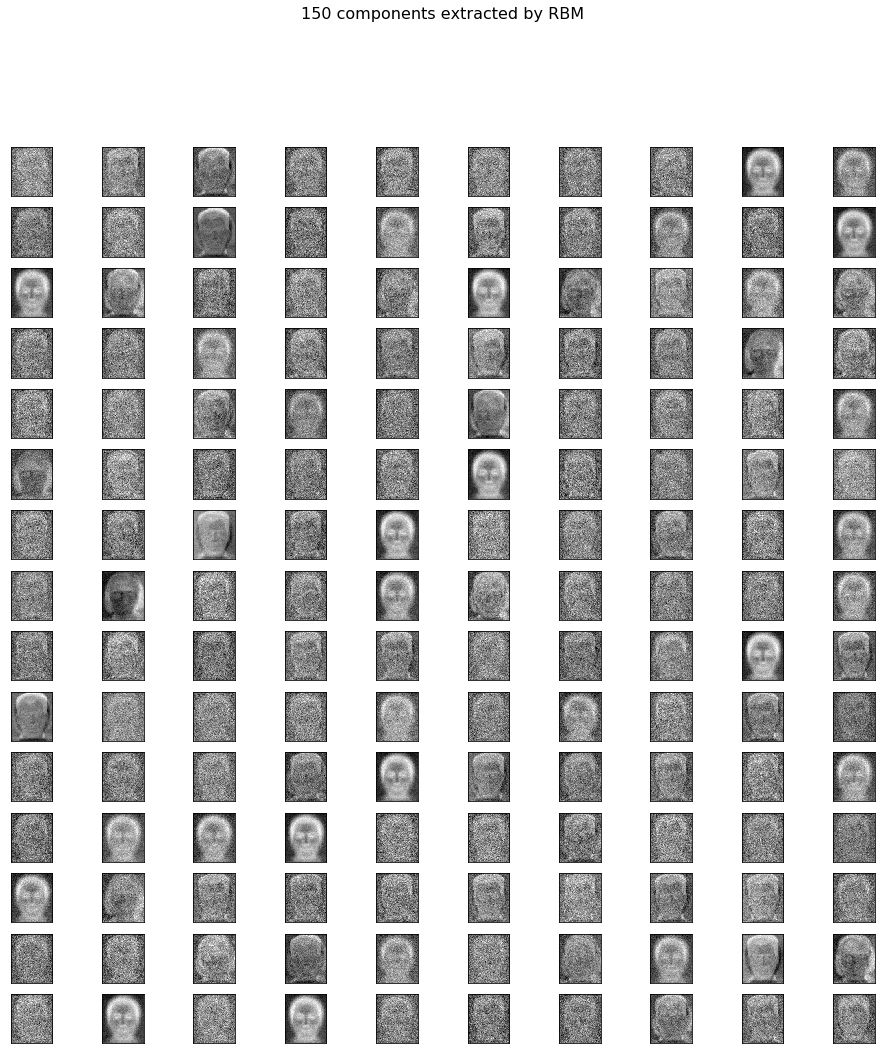

In [13]:
#Let's view the 150 components created by the RBM
# ??? ISN'T THIS 165, DID GUY GET WRONG, AND ERROR, OR MY MISUNDERSTANDING?
# !!! ASK ZACH

plt.figure(figsize=(15, 15))
for i, comp in enumerate(rbm.components_[:150]):
    plt.subplot(15, 10, i + 1)
    plt.imshow(comp.reshape((77, 65)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('150 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

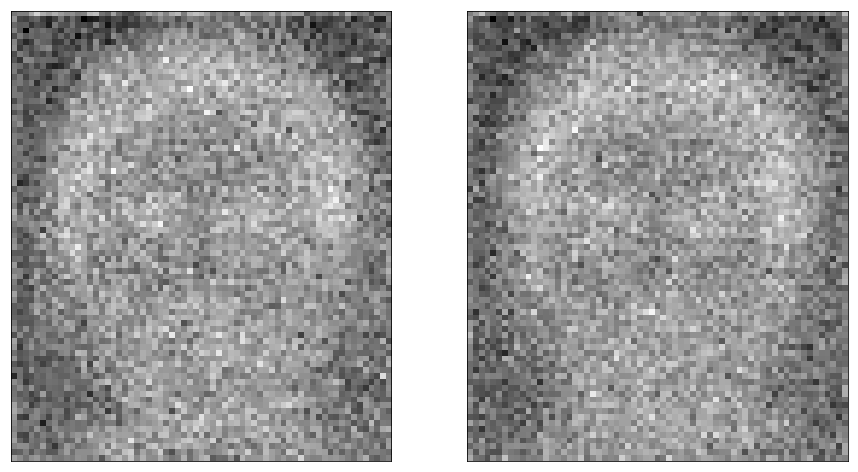

In [28]:
# SELECTED FEATURES EXAMINATION
first = 3
second = 45

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(rbm.components_[first].reshape((77, 65)), cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.xticks(())
plt.yticks(())
plt.subplot(122)
plt.imshow(rbm.components_[second].reshape((77, 65)), cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.xticks(())
plt.yticks(())
plt.show()

In [15]:
X = np.asarray(imgsarr, 'float32')
X_big, Y_big = nudge_dataset(X, y)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_big, Y_big, test_size=0.2, random_state=0)

In [17]:
#Redefine the RBM
rbm = BernoulliRBM(random_state=0, verbose=True, learning_rate=.01,
                  n_iter=20, n_components=150)

#Redefine the Logistic Classifier
logistic = LogisticRegression(solver='lbfgs', max_iter=10000,
                              C=6000, multi_class='multinomial')

#Combine the two into a Pipeline
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [18]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -2394.84, time = 1.89s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -2353.09, time = 1.91s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -2373.94, time = 1.76s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -2384.29, time = 1.77s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -2351.87, time = 1.78s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -2346.78, time = 1.88s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2361.84, time = 1.89s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -2348.80, time = 2.26s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -2340.15, time = 1.85s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2370.71, time = 1.81s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -2343.36, time = 1.95s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2340.61, time = 1.77s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -2367.05, time = 1.94s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -2377.69, time = 1.90s
[

Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.01,
                              n_components=150, n_iter=20, random_state=0,
                              verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [19]:
# Training the Logistic regression classifier directly on the pixel
# !!! IS THIS CORRECT TO FROM MNIST EXAMPLE IN SCIKITLEARN
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
# Evaluation
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.08      1.00      0.15         7
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.14      1.00      0.24        10
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        18
          15       0.00      0.00      0.00        16

    accuracy                           0.10       165
   macro avg       0.01      0.13      0

C:\Users\DJ\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        18
          15       1.00      1.00      1.00        16

    accuracy                           1.00       165
   macro avg       1.00      1.00 

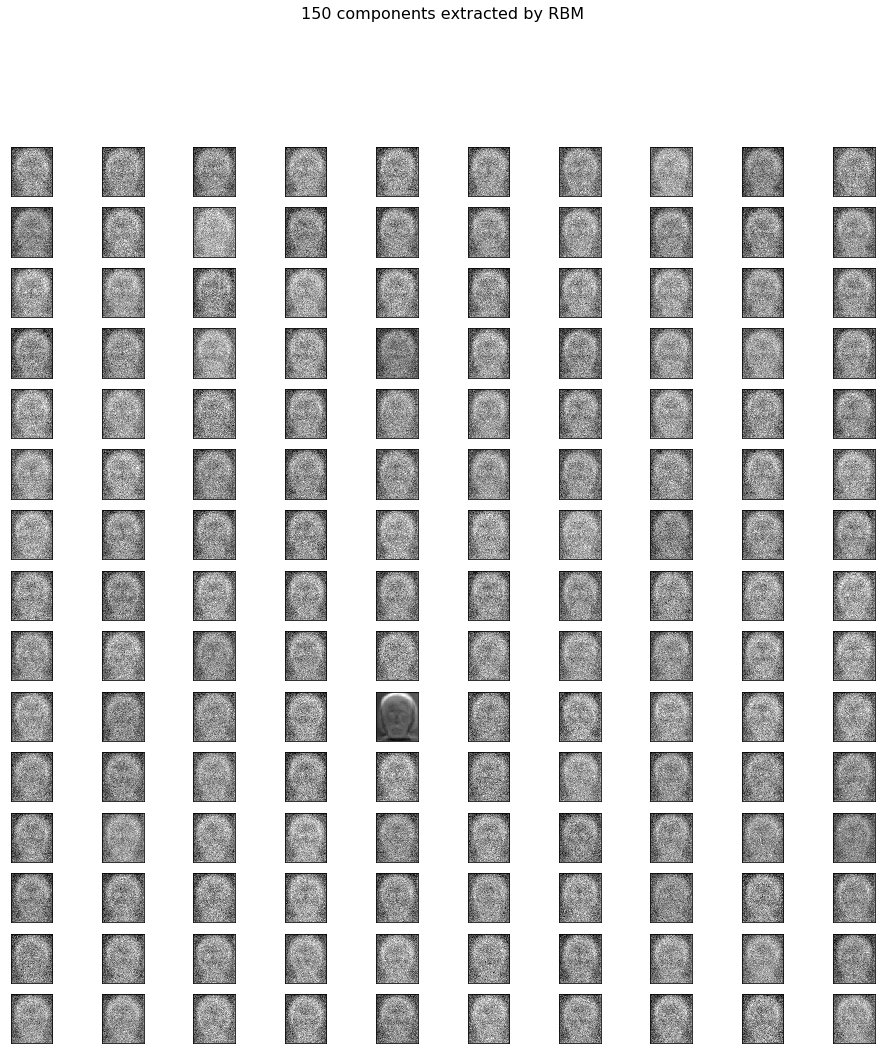

In [22]:
# Plotting

plt.figure(figsize=(15, 15))
for i, comp in enumerate(rbm.components_):
    plt.subplot(15, 10, i + 1)
    plt.imshow(comp.reshape((77, 65)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('150 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

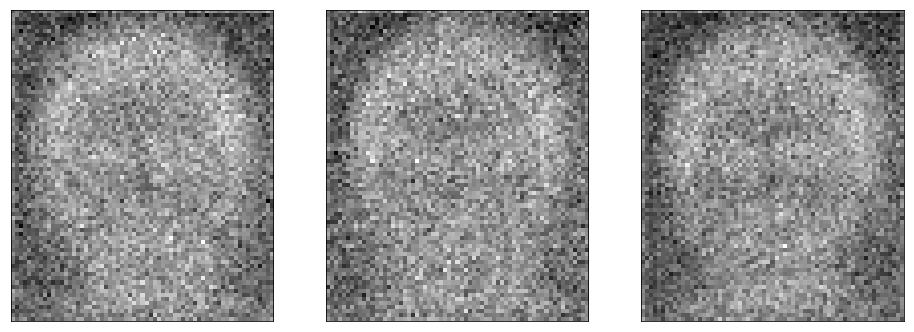

In [24]:
#Selected features for closer examination
toshow = [0,1,2]

plt.figure(figsize=(16, 10))
for i, comp in enumerate(toshow):
    plt.subplot(1,3,i+1)
    plt.imshow(rbm.components_[comp].reshape((77, 65)), cmap=plt.cm.gray_r,
           interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show()

#### Analysis:
Images don't appear to make sense to human eye, but on a pixel level are able to predict test set perfectly.